# PCHN63101 Regression Workshop
In the accompanying lesson to this workshop we explored both simple and multiple regression as core modelling tools in statistics. Indeed, regression is the foundation of *everything* we will be studying going forward. Once you understand regression, you understand the vast majority of applied statistics. Because of this, it is *essential* that you are as comfortable as possible with the regression framework, otherwise you will be lost going forward. In this workshop, the aim is to provide more concrete examples of many of the key concepts from the lesson. As with last week, demonstrating statistical theory within `R` allows you to gain more intuition, particularly as you can play around with the code and see the consequences. It can also help you gain a more detailed understanding of the mathematical notation by seeing it represented within code. Together, this should help solidify your understanding of many of the ideas behind regression, statistical models, estimation, visualisation and the `R` formula interface.    

## Minimising Error With a Line
To begin with, we will explore the idea of the "best" regression line being the one that *minimises* the error sums-of-squares. Although easy enough to state that the least-squares solutions are the ones that make this quantity as *small* as possible, it can be useful to actually demonstrate this. The code below is set to produce a regression line, which is visualised in the plot below. Do not worry about the code that adjusts the plot limits, this is just to prevent the regression line from disappearing from the plot view, no matter the chosen parameter values. The important point is that the error sums-of-squares are displayed in the title of the plot.

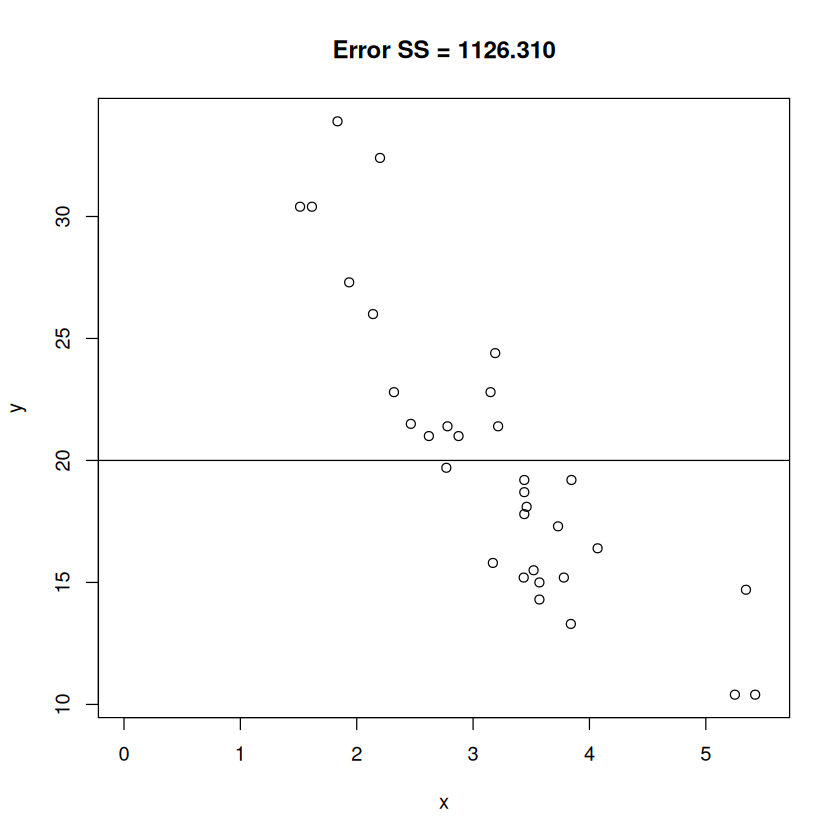

In [1]:
data(mtcars)
y <- mtcars$mpg
x <- mtcars$wt

# regression parameters
beta.0 <- 20
beta.1 <- 0 
y.hat  <- beta.0 + beta.1*x

# error sum-of-squares
error.SS  <- sum((y - y.hat)^2)

# figure out y-limits based on the range of estimated values and the data
est.lims  <- c(beta.0 + beta.1*min(x),
               beta.0 + beta.1*max(x))
est.range <- c(min(est.lims),max(est.lims))
plot.lim  <- c(min(min(y),est.range[1]), 
               max(max(y),est.range[2]))

# printing precision of the error SS (e.g. %.5f would display 5 decimal places)
ESS.print <- sprintf("%.3f",error.SS) 

# plot data and regression line
plot(x, y, main=paste0("Error SS = ", ESS.print), ylim=plot.lim, xlim=c(0,5.5))
abline(coef=c(beta.0,beta.1))

<div class="alert alert-block alert-info"> 
<b>ACTIVITY</b> Try changing the values of <code>beta.0</code> and <code>beta.1</code> in the code above. Can you find the OLS estimates by making the error sum-of-squares as small as possible? You can move the line up and down by changing <code>beta.0</code> and then adjust its angle using <code>beta.1</code>.
</div>

## Maximum Likelihood
In the accompanying lesson, we discussed both *least-squares* and *maximum likelihood* as options for estimating regression models. Due to its simplicity and the availbility of closed-form solutions, least-squares is usually preferred for regression problems. However, maximum likelihood is preferred more generally because it can be applied to situations where no closed-form solution exists. This is particularly true of models that that use a *different* distributions to the normal distribution. As such, if there is a *single* estimation approach we should try to understand, it is maximum likelihood.

Although possible to derive closed-form solutions using maximum likelihood, for situations where this is not possible we can make use of *iterative* maximum likelihood. Effectively, this involves getting the computer to search through hundreds or thousands of guesses for the parameters to try and find the "best" ones. This is effectively what you were doing in the example above. So, let us start by saving the least-squares estimates so we can compare.

In [2]:
mod             <- lm(mpg ~ wt, data=mtcars)
ols.ests        <- coef(mod)
ols.ests        <- c(ols.ests, summary(mod)$sigma)
names(ols.ests) <- c("beta.0", "beta.1", "sigma")

print(ols.ests)

   beta.0    beta.1     sigma 
37.285126 -5.344472  3.045882 


<div class="alert alert-block alert-info"> 
<b>ACTIVITY</b> How close were you to finding the OLS estimates in the example earlier? Try inserting the OLS estimates into that code and see how close the true minimum error sum-of-squares was to the value you managed to get. <b>HINT</b> If you are very close, you may need to adjust the printing precision of the error sums-of-squares to see it.
</div>

In the field of numeric computing, methods that search around to find the "best" parameters are known as *optimisation* algorithms. To gain a bit more intuition about this, we will have a brief look at optimisation within the context of maximum likelihood. In practice, you would never need to implement this type of approach yourself, but it can be helpful to see it when learning. Within `R`, the functions `nlm()` can be used for optimisation (`n`on`l`inear `m`inimisation). This function needs some starting guesses for the parameters, so in the example below we set `beta.0 <- mean(y)`, `beta.1 <- 0`, `sigma <- sd(y)`. As the name implies, this function *minimises*, so we need to return the *negative* log-likelihood. 

In [3]:
# Define negative log-likelihood function
neg.loglik <- function(params) {
  beta.0 <- params[1]
  beta.1 <- params[2]
  sigma  <- params[3]

  if (sigma <= 0) return(1e10)

  mu     <- beta.0 + beta.1*x    
  loglik <- sum(dnorm(y, mean=mu, sd=sigma, log=TRUE)) # log-likelihood
  return(-loglik)                                      # -ve log-likelihood
}

# data
x <- mtcars$wt
y <- mtcars$mpg

# Starting values (guesses for intercept, slope and SD)
init.params <- c(mean(y), 0, sd(y))

# Run optimisation
mle <- nlm(f=neg.loglik, p=init.params)

# Results
mle.ests        <- mle$estimate
names(mle.ests) <- c("beta.0", "beta.1", "sigma")

# Print
cat(paste0("MLE Estimation complete in ", mle$iterations, " iterations\n\n"))
cat("MLE estimates:\n")
cat(mle.ests)
cat("\n\nOLS estimates:\n")
cat(ols.ests)

MLE Estimation complete in 15 iterations

MLE estimates:
37.28513 -5.344472 2.949163



OLS estimates:
37.28513 -5.344472 3.045882

<div class="alert alert-block alert-info"> 
<b>ACTIVITY</b> Try changing the starting values in <code>init.params</code>. What does this do to the number of iterations required? Can you break the estimation and get the algorithm to converge on very different parameter estimates? What does this tell you about the process of optimisation?
</div>

As we can see above, and as explained in the lesson, the variance estimation from maximum likelihood is *biased* as it does not implement Bessel's correction. Restricted maximum likelihood (REML) is therefore the preferred option in practice. However, this is more complex to demonstrate and so we will not discuss it in any more detail.

## Different Model Equations
Within the accompanying lesson, we discussed how the regression model can be written two equivalent ways:

$$
y_{i} \sim \mathcal{N}\left(\beta_{0} + \beta_{1}x_{i}, \sigma^{2}\right)
$$

or

$$
\begin{alignat*}{1}
    y_{i}        &=    \beta_{0} + \beta_{1}x_{i} + \epsilon_{i} \\
    \epsilon_{i} &\sim \mathcal{N}\left(0, \sigma^{2}\right)
\end{alignat*}
$$

Students sometimes find this confusing and struggle to connect the two. To help, we have provided code below that shows simulated data generated using *both* forms of model equation. As long as we set the random seed to the same number each time, we can show that the simulated data is *identical*.

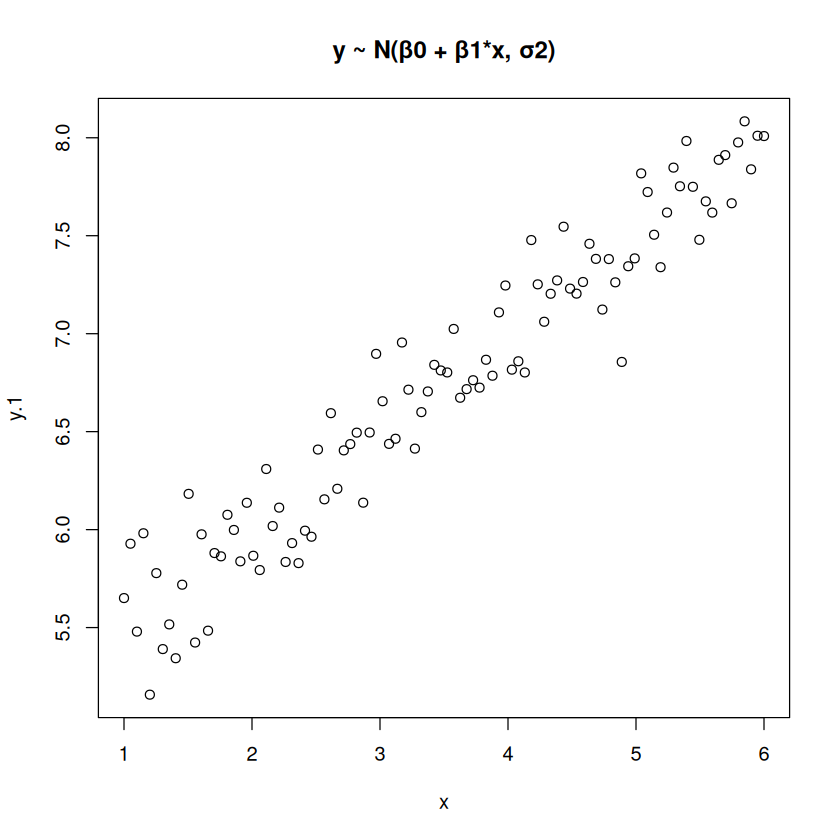

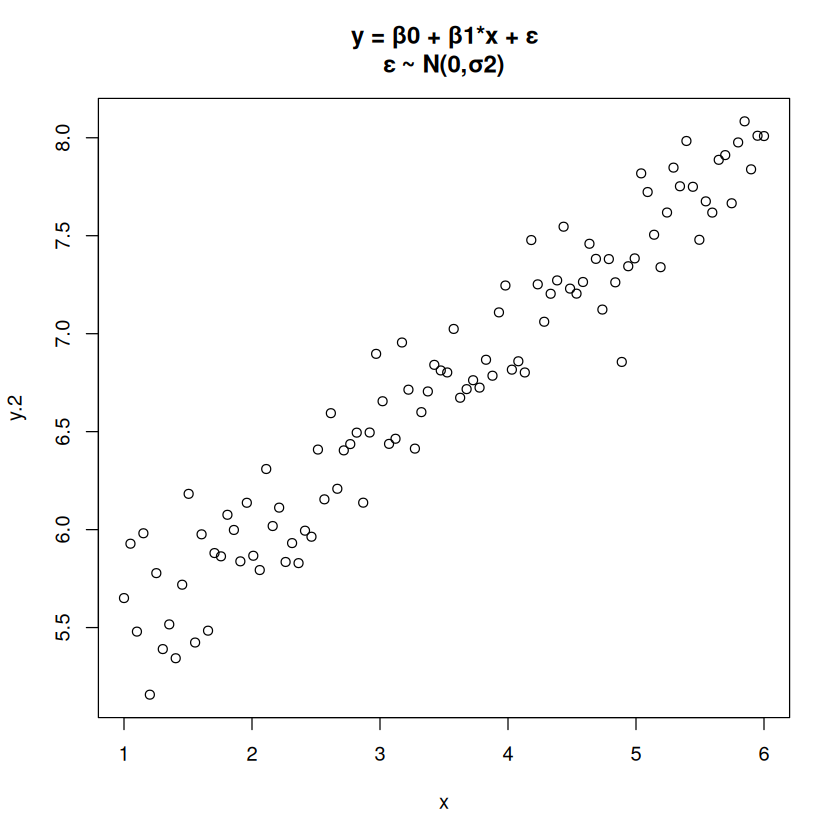

In [4]:
n      <- 100
x      <- seq(from=1, to=6, length.out=n)
beta.0 <- 5
beta.1 <- 0.5
sigma  <- 0.2

set.seed(666)
#===================================================#
# y ~ N(beta.0 + beta.1*x, sigma)                   #
#===================================================#
y.1 <- rnorm(n=n, mean=beta.0 + beta.1*x, sd=sigma)

set.seed(666)
#===================================================#
# y = beta.0 + beta.1*x + e                         #
# e ~ N(0, sigma)                                   #
#===================================================#
err <- rnorm(n=n, mean=0, sd=sigma)
y.2 <- beta.0 + beta.1*x + err

# plots
plot(x, y.1, main="y ~ N(β0 + β1*x, σ2)")
plot(x, y.2, main="y = β0 + β1*x + ε\nε ~ N(0,σ2)")

The key to understanding the equivalence is recognising that it is only the deviations from the line that are random, whereas the regression equation is fixed. In the first form, this is implicit because we set the mean of the normal distribution (the *fixed*, *predictable* or *systematic* part) to the regression line and then sample data from around that point. In the second form, this is more explicit because we effectively generate the regression line and then *add* random noise to it. 

This second form can be thought of as simply "line + error". For each value of $x$, the line is *constant*, whereas the data that floats around the line changes with each sample. So it is the *deflections from the line* that are random, *not* the line itself. Hence, the errors are a random variable. They are where the randomness comes from. So, our systematic variance is fixed and predictable (a *constant*) whereas the errors changes with each observation (a *random variable*). We can see this more clearly in the plots below. Adding the first plot to the second plot gives the final model in the third plot. The model is simply the *addition* of both these elements: the fixed line *plus* the random error.

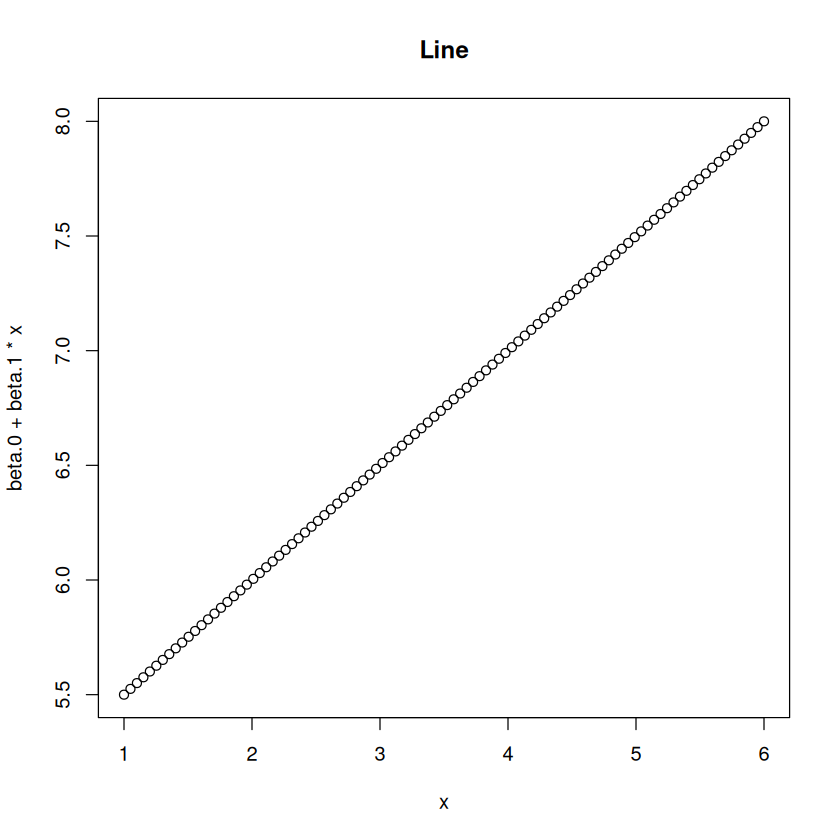

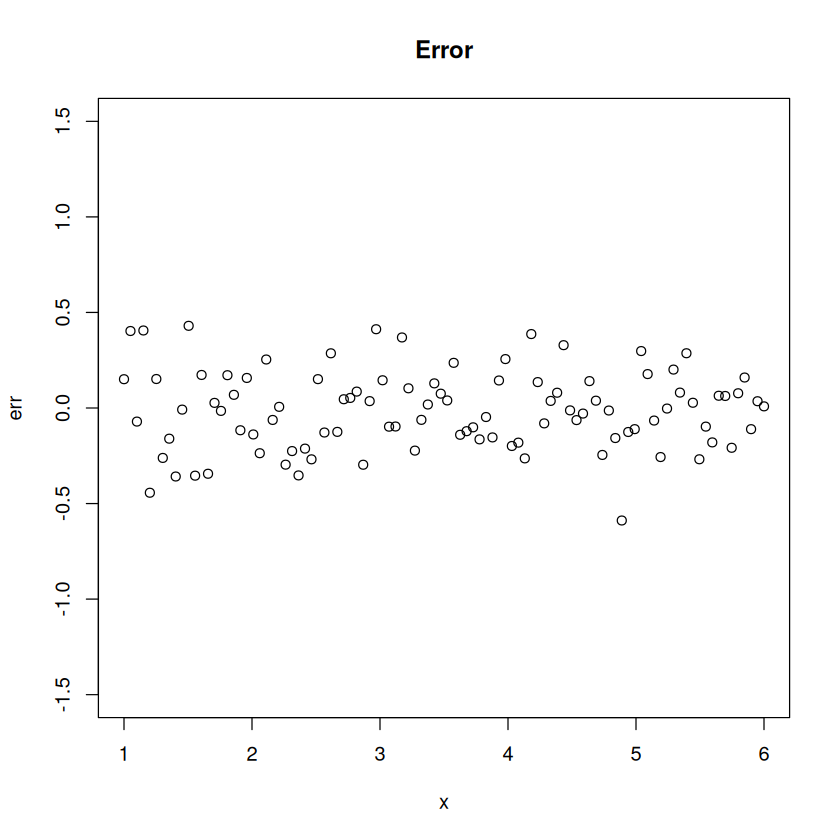

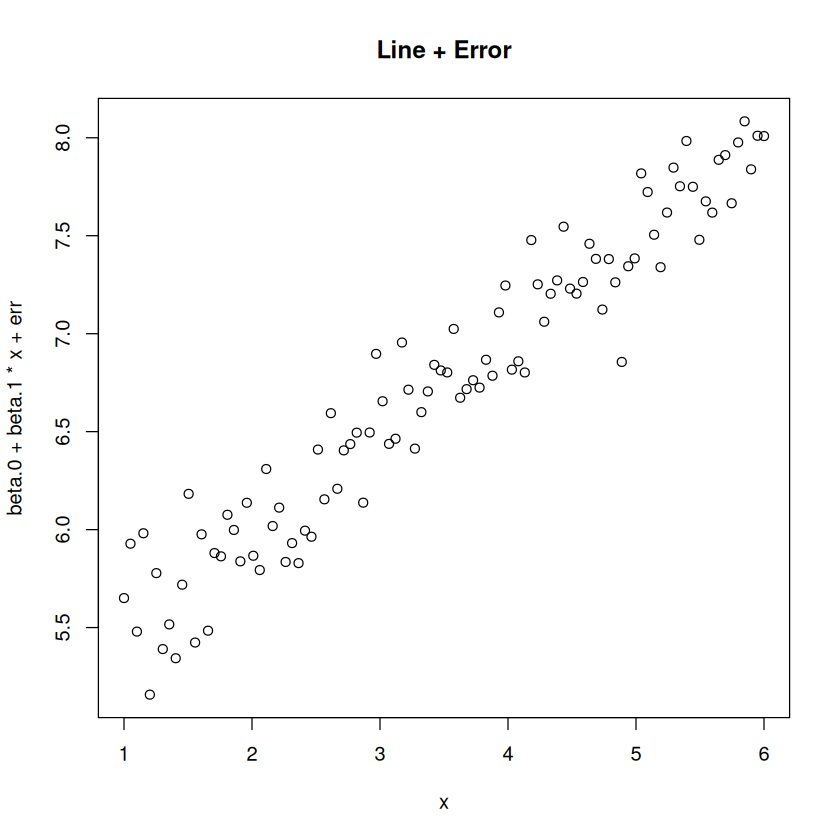

In [5]:
plot(x,beta.0 + beta.1*x,       main="Line")         # fixed line
plot(x,err, ylim=c(-1.5,1.5),   main="Error")        # random error
plot(x,beta.0 + beta.1*x + err, main="Line + Error") # fixed line + random error (full model)

<div class="alert alert-block alert-info"> 
<b>ACTIVITY</b> Focus on the plot of errors above. Why is the mean of the errors 0? Why is the data evenly scattered above and below 0? Why does this scattering appear constant for all values of <code>x</code>?
</div>

## Regression as a Mean and Variance Function
To further help conceptualise the regression model, we can return to the concept of a *mean function* and a *variance function*. In the workshop last week, we demonstrated the idea of a mean and variance function in code as *programming functions*. We hinted at how this applied to regression, but we will see it more explicitly now.

In terms of code, if we continue with our `mpg` and `wt` example, a simple regression mean and variance function would be

In [6]:
mean.func <- function(i,x,mod){
    beta.0 <- coef(mod)[1]
    beta.1 <- coef(mod)[2]
    mu.i   <- beta.0 + beta.1*x[i]
    return(mu.i)
}

var.func <- function(i,x,mod){
    sigma <- summary(mod)$sigma
    return(sigma^2)
}

Here we can that the mean function implements the *rule* for calculating the mean based on the estimated parameter values. This rule is given by the regression equation. The variance function does the same thing, but the rule is very simple as it just returns the same value irrespective of the observation or value of the predictor variable.

One point of connection here is that the *predicted* or *fitted* values from the regression model are *precisely* the results given by the mean function for each value of the predictor variable. This should not be a surprise, as the mean function implements the *expected value* of the assumed distribution. With no other information to hand, these are exactly the values we would predict as they represent the *systematic* variance that we expect to always be stable. Let us see this in code.

In [7]:
n      <- length(mtcars$mpg)
x      <- mtcars$wt
pred.y <- rep(0,n)
mod    <- lm(mpg ~ wt, data=mtcars)

for (i in 1:n){
    pred.y[i] <- mean.func(i,x,mod)
}

fit <- fitted(mod)

print(data.frame("mean.func" = pred.y,
                 "fitted"    = fit))

                    mean.func    fitted
Mazda RX4           23.282611 23.282611
Mazda RX4 Wag       21.919770 21.919770
Datsun 710          24.885952 24.885952
Hornet 4 Drive      20.102650 20.102650
Hornet Sportabout   18.900144 18.900144
Valiant             18.793255 18.793255
Duster 360          18.205363 18.205363
Merc 240D           20.236262 20.236262
Merc 230            20.450041 20.450041
Merc 280            18.900144 18.900144
Merc 280C           18.900144 18.900144
Merc 450SE          15.533127 15.533127
Merc 450SL          17.350247 17.350247
Merc 450SLC         17.083024 17.083024
Cadillac Fleetwood   9.226650  9.226650
Lincoln Continental  8.296712  8.296712
Chrysler Imperial    8.718926  8.718926
Fiat 128            25.527289 25.527289
Honda Civic         28.653805 28.653805
Toyota Corolla      27.478021 27.478021
Toyota Corona       24.111004 24.111004
Dodge Challenger    18.472586 18.472586
AMC Javelin         18.926866 18.926866
Camaro Z28          16.762355 16.762355


So, here, we can see that the values returned by the `fitted()` function and the values calculated by our mean function are identical. So, the *fitted* or *predicted* values can be conceptualised as the values returned by the mean function. If we then plot these values, it should not be surprising to see that they are *exactly* the points on the regression line for our measured values of `wt`.

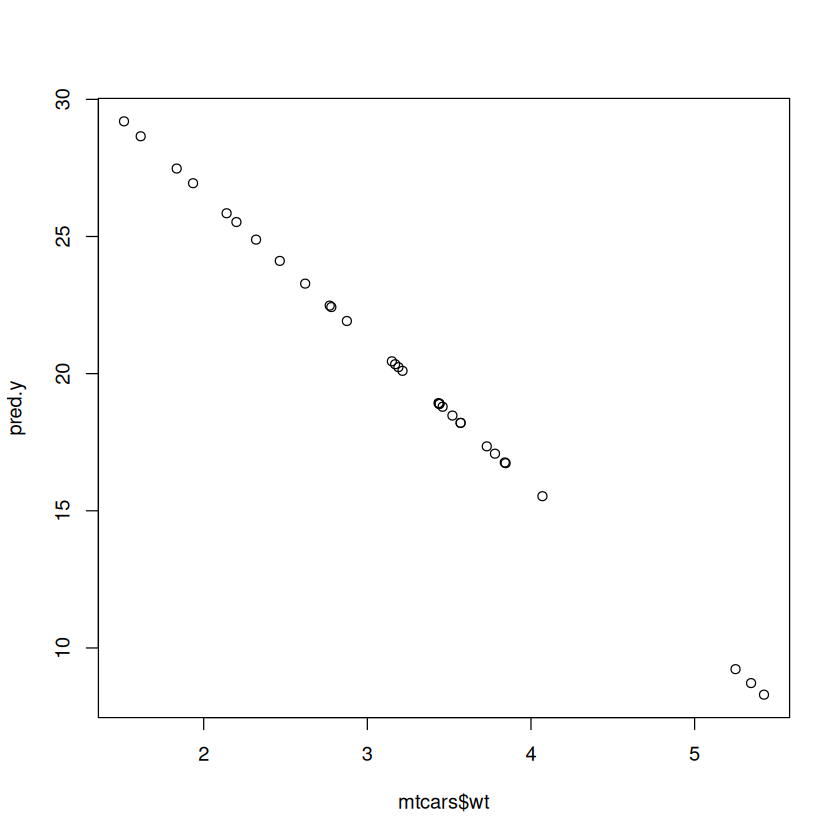

In [8]:
plot(mtcars$wt,pred.y)

From this perspective, the mean function *is* our model of the data. It captures the non-random systematic patterns we can see. This is conceptualised in terms of the *expected value* of a particular probability distribution which, in this example, changes depending upon the value of the predictor variable. This change in the expected values is given *precisely* by the regression line. Indeed, we can think of the regression line as a representation of how the mean of the normal distribution changes for different values of the predictor variable.

<div class="alert alert-block alert-info"> 
<b>ACTIVITY</b> As well as just predicting values for the current measurements of <code>wt</code>, our mean function allows us to predict values of <code>mpg</code> from <i>any</i> values of <code>wt</code>. Can you use the <code>seq()</code> function to generate an even spread of <code>wt</code> values between 1 and 6? Can you then use the mean function to generate predictions that fill the gap between 4 and 5 we see in the actual data?
</div>

Note that if we wanted to simulated predicted values from a model in `R`, we do not have to construct our own mean function. Instead, we can do the same thing with the built-in `predict()` function. This takes as arguments a model and a *new* data frame containing the values of the predictors we want to use for the simulation. Just be aware that these predictors must be named *identically* to the originals in order for this to work.

### Predictive Accuracy
Another thing we can do is simulate some data based on this model and see whether it looks similar to the data we have measured. This simulated data will capture the *general pattern* in the data (the systematic variance) as well as the *spread* around the regression line (the random error variance). In the example below, we use the `seq()` function to generate a range of $x$-values from 1 to 6. We then replicate this range 3 times, so that we will end up simulating 3 value of $y$ for each value of $x$ (to give us some vertical spread). We then simulate each $y$-value using the mean and variance functions. The result of the simulation is plotted, with the true data in the plot below.

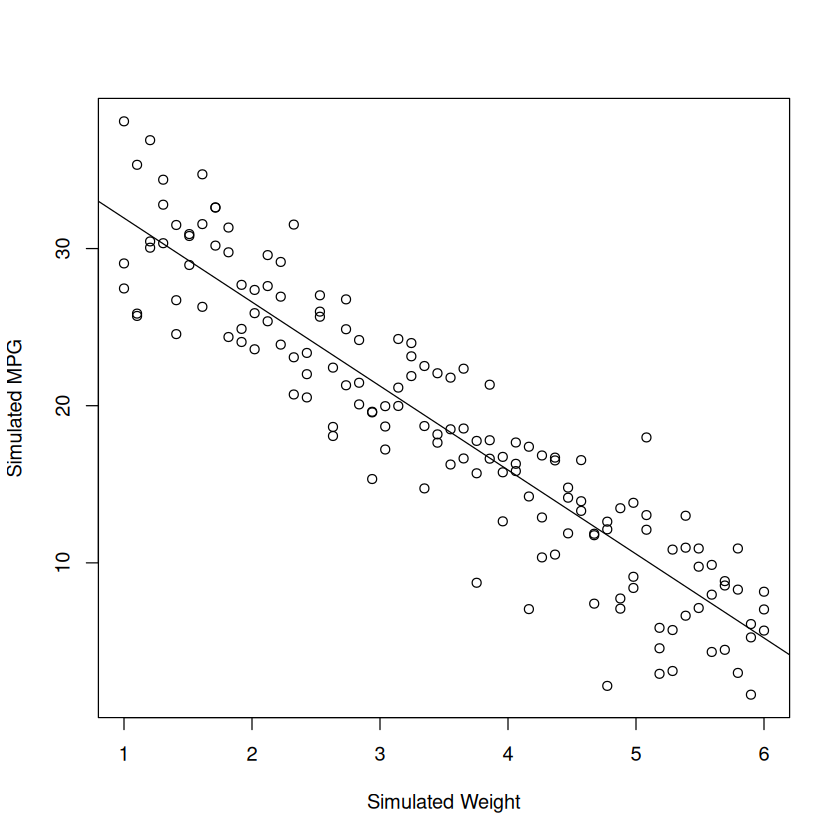

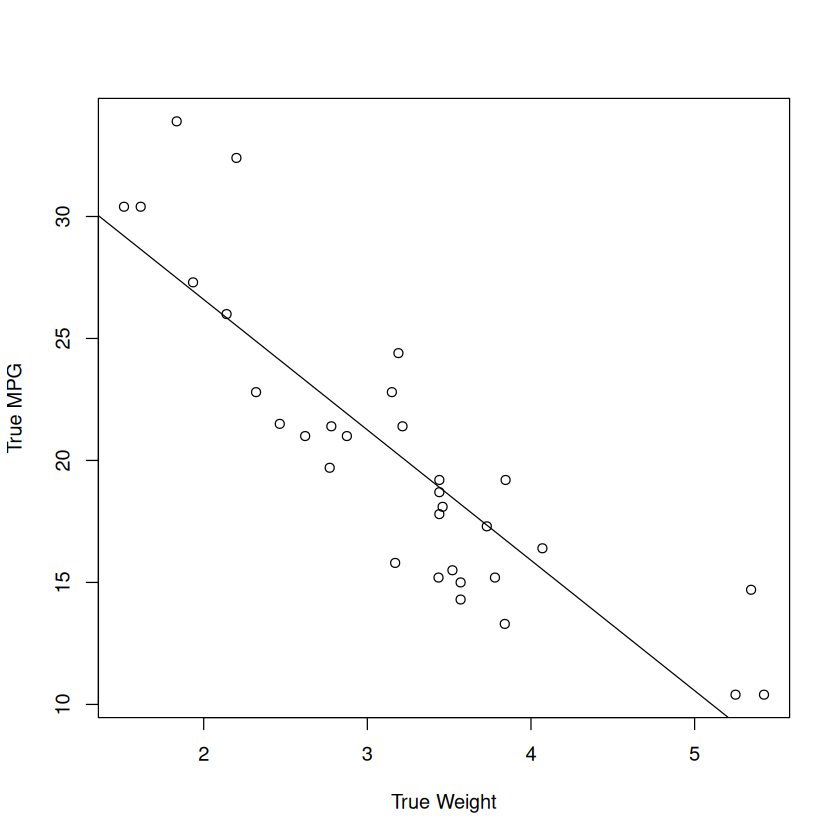

In [9]:
# control the number of simulated values
n.x    <- 50
n.reps <- 3

# generate x values
x <- seq(from=1, to=6, length.out=n.x)
x <- rep(x, n.reps)

# simulate y
nsubs <- length(x)
y.sim <- rep(0,nsubs)
for (i in 1:nsubs){
    y.sim[i] <- rnorm(n=1, mean=mean.func(i,x,mod), sd=sqrt(var.func(i,x,mod)))
}

# plot
plot(x, y.sim, xlab="Simulated Weight", ylab="Simulated MPG")
abline(reg=mod)

plot(mtcars$wt, mtcars$mpg, xlab="True Weight", ylab="True MPG")
abline(reg=mod)

<div class="alert alert-block alert-info"> 
<b>ACTIVITY</b> Have a play around with the values of <code>n.x</code> and <code>n.reps</code> in the code above. These control how many values of <code>wt</code> are included in the simulations, as well as how many cars at each value of <code>wt</code> we measure. Do you think these simulations reflect our data accurately?
</div>

Notice that this simulation does *not* reflect the fact that, in the real data, at both lower and higher values of `wt`, the measures of `mpg` lie *above* the regression line. So while this simulation matches some elements of the data, it does not match all of them. Indeed, as we will see in future weeks, a *curved* line may be a better fit here than a *straight* line. We can see this as the curved yellow line in the plot below. We will discuss this type of visualisation in more detail a little later on the unit, so do not worry about it for now. Just make sure it is clear that the simulated data is based on assuming the straight-line fit is accurate. The simulation is what our model says the data-generating process is, but we need to be sure that this agrees with what we can *actually* see.

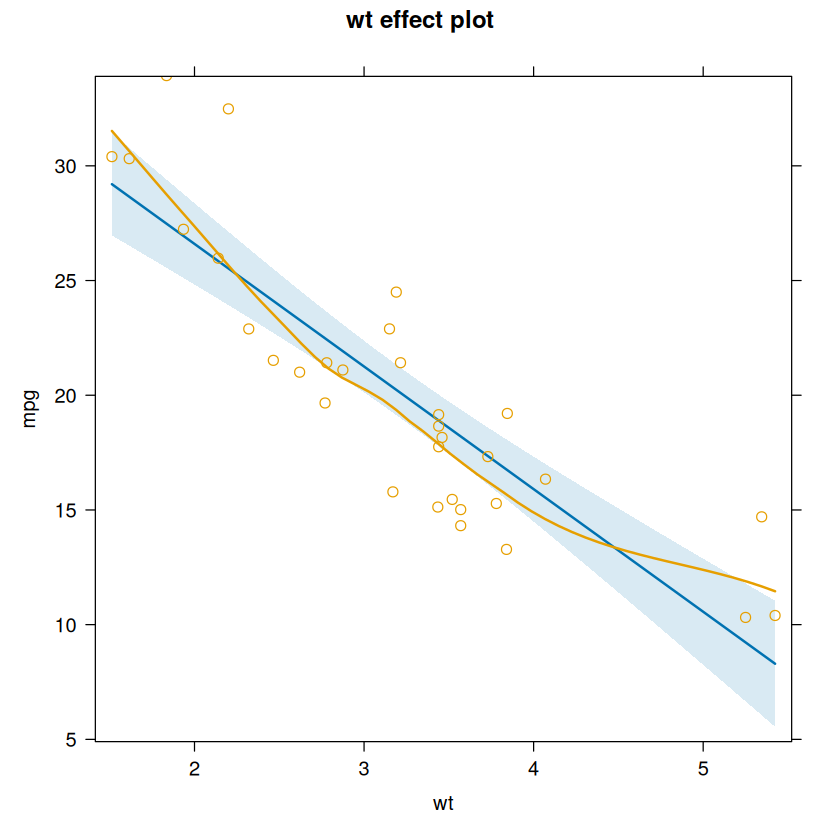

In [10]:
suppressMessages(library(effects))    # stop startup messages being printed
plot(allEffects(mod, residuals=TRUE)) # plot the model prediction

## Intercepts and the `R` Formula Interface
In this part of the workshop, we will dig into the `R` formula interface a little more, particularly in relation to the *intercept* of the regression model. Students can often get confused by the intercept, as well as how it can be specified (or removed) in `R`. We will try to gain some intuition about both these aspects.

### Declaring an Intercept
To begin with, all models fit with `lm()` will *implicitly* contain an intercept. We can make this inclusion more *explicit* by using the format `y ~ 1 + x1`. For example

In [11]:
mod.1 <- lm(mpg ~ wt,     data=mtcars) # intercept implied
mod.2 <- lm(mpg ~ 1 + wt, data=mtcars) # intercept explicit

mod.1
mod.2


Call:
lm(formula = mpg ~ wt, data = mtcars)

Coefficients:
(Intercept)           wt  
     37.285       -5.344  



Call:
lm(formula = mpg ~ 1 + wt, data = mtcars)

Coefficients:
(Intercept)           wt  
     37.285       -5.344  


As we can see, these two models are *identical*, so it really depends upon whether you find the explicit declaration of the intercept more appealing, or are happy to leave it out.

### Removing the Intercept
Because the intercept is always *implicit*, it we want to remove it from the model we have to tell `lm()` to do this specifically. There are two ways to go about this. We either mirror the explicit declaration of an intercept and replace the `1` with a `0`, or we use a `-1` to tell `lm()` to *remove* the intercept. We can also do both, if we like being unnecessarily verbose. For example

In [12]:
mod.1 <- lm(mpg ~ 0 + wt,     data=mtcars) # an intercept of 0
mod.2 <- lm(mpg ~ wt - 1,     data=mtcars) # remove intercept
mod.3 <- lm(mpg ~ 1 + wt - 1, data=mtcars) # include intercept, then remove it

mod.1
mod.2
mod.3


Call:
lm(formula = mpg ~ 0 + wt, data = mtcars)

Coefficients:
   wt  
5.292  



Call:
lm(formula = mpg ~ wt - 1, data = mtcars)

Coefficients:
   wt  
5.292  



Call:
lm(formula = mpg ~ 1 + wt - 1, data = mtcars)

Coefficients:
   wt  
5.292  


You can use whichever format feels most intuitive to you. Most examples of `lm()` that you will see in the wild use the `y ~ x1` and `y ~ x1 - 1` formats, though you may personally prefer `y ~ 1 + x1` and `y ~ 0 + x1` as it makes the model form clearer. Just note that if you want a model that *only* contains an intercept, the only option is

In [13]:
mod <- lm(mpg ~ 1, data=mtcars) # intercept only
mod


Call:
lm(formula = mpg ~ 1, data = mtcars)

Coefficients:
(Intercept)  
      20.09  


You can even specify a model without anything in it by writing an intercept-only model using `0`. Why you would want this is anyone's guess, but it is possible.

In [14]:
mod <- lm(mpg ~ 0, data=mtcars) # model containing nothing
mod


Call:
lm(formula = mpg ~ 0, data = mtcars)

No coefficients


### Formula Shortcuts
There are also some other symbols you can use in the model formula as shortcuts. For instance, using `.` instead of the variable names means "include everything in the dataset". So, if we did that here, we get a model that contains *everything* from `mtcars`

In [15]:
mod.all <- lm(mpg ~ ., data=mtcars)
mod.all


Call:
lm(formula = mpg ~ ., data = mtcars)

Coefficients:
(Intercept)          cyl         disp           hp         drat           wt  
   12.30337     -0.11144      0.01334     -0.02148      0.78711     -3.71530  
       qsec           vs           am         gear         carb  
    0.82104      0.31776      2.52023      0.65541     -0.19942  


We can also use the `-` symbol to exclude certain variables from inclusion. For instance, to include everything *except* `gear`, we would use

In [16]:
mod.nogear <- lm(mpg ~ . - gear, data=mtcars)
mod.nogear


Call:
lm(formula = mpg ~ . - gear, data = mtcars)

Coefficients:
(Intercept)          cyl         disp           hp         drat           wt  
   15.64181     -0.27315      0.01395     -0.02063      0.84089     -3.86609  
       qsec           vs           am         carb  
    0.79507      0.35800      2.80345     -0.04506  


If we then wanted to add `gear` in, we can either repecify the model using `lm()`, or we can use the `update()` function like so

In [17]:
mod.withgear <- update(mod.nogear, ~ . + gear)
mod.withgear


Call:
lm(formula = mpg ~ cyl + disp + hp + drat + wt + qsec + vs + 
    am + carb + gear, data = mtcars)

Coefficients:
(Intercept)          cyl         disp           hp         drat           wt  
   12.30337     -0.11144      0.01334     -0.02148      0.78711     -3.71530  
       qsec           vs           am         carb         gear  
    0.82104      0.31776      2.52023     -0.19942      0.65541  


Here, the `.` in the formula simply means "everything that was included before".

### Regression Through the Origin
Returning to the idea of *removing* an intercept, sometimes the temptation is to exclude an intercept term when we feel that a value of 0 on the predictor variable should be matched with a predicted value of 0. For instance, in the case of `wt` it feels more sensible to have the model predict that a car with 0 weight has an MPG of 0, rather than predicting a large positive value of MPG for a weight of 0. However, this is not always the best choice.

To see this, we will specify the model between `wt` and `mpg` *without* an intercept. This is known as a *regression through the origin*. We plot the results of this below.

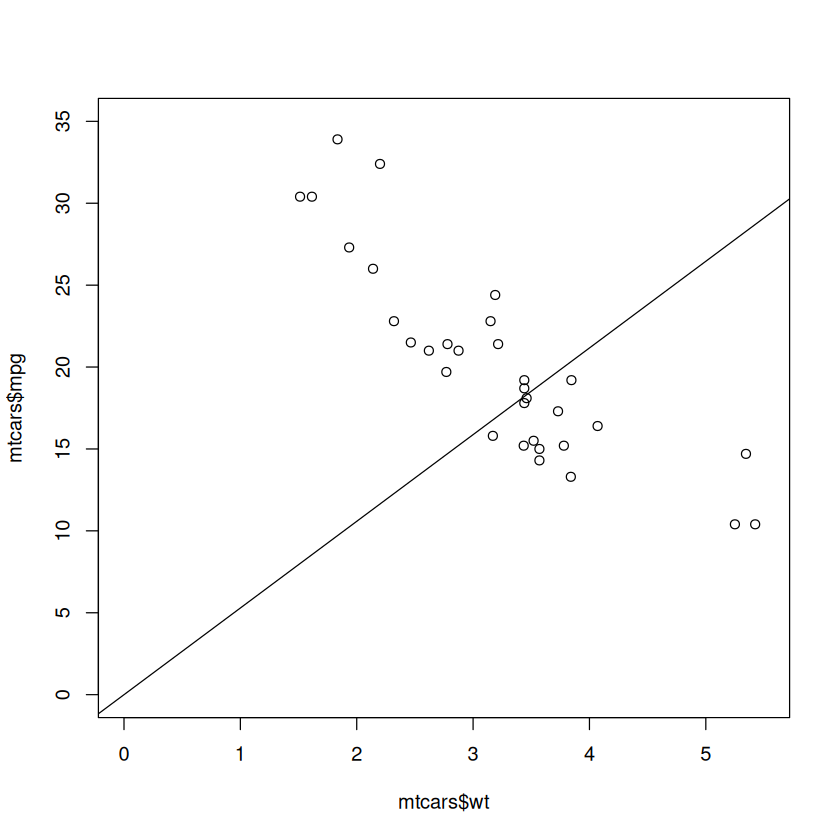

In [18]:
reg.through.orig <- lm (mpg ~ 0 + wt, data=mtcars)
plot(x=mtcars$wt, y=mtcars$mpg, xlim=c(0,5.5), ylim=c(0,35))
abline(reg=reg.through.orig)

So, we now have a model where the prediction for 0 weight is indeed 0 MPG. So this is good. Unfortunately, we cannot say the same for anything else about this model. While *technically* the prediction for a weight of 0 is now sensible, forcing a straight line to pass through 0 clearly does not match the actual data.

The way to think about this type of model is that it needs to be *constrained* to only a sensible range of the `wt` variable. Cars will have a minimum and maximum weight. Any value outside that range is uninterpretable and should be ignored. Indeed, a car with a weight of 0 is a nonsense. Even if the regression model can technically calculate MPG for an infinite range of weights, the problem itself should constrain the use of this model to only realistic values. As such, the fact that the intercept is not very meaningfully can simply be ignored.


### Mean Centering
As an alternative, if we find the interpretation of the intercept particularly distasteful, we can choose to *mean-centre* the weight variable. This is a simple operation where we subtract the mean of weight from each observation. This renders the average of the centred variable 0, with each observation now representing a *deflection* from the mean. Let us see what this does to the intercept parameter estimate.

In [19]:
wt.cent  <- mtcars$wt - mean(mtcars$wt)
reg.cent <- lm(mpg ~ wt.cent, data=mtcars)
summary(reg.cent)


Call:
lm(formula = mpg ~ wt.cent, data = mtcars)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.5432 -2.3647 -0.1252  1.4096  6.8727 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  20.0906     0.5384  37.313  < 2e-16 ***
wt.cent      -5.3445     0.5591  -9.559 1.29e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.046 on 30 degrees of freedom
Multiple R-squared:  0.7528,	Adjusted R-squared:  0.7446 
F-statistic: 91.38 on 1 and 30 DF,  p-value: 1.294e-10


So now, the value of the intercept is the estimated MPG for an *average* value of `wt`. This is potentially more helpful, because we can see that an average car (in terms of weight) has an associated fuel efficiency of around 20.1 MPG. Of importance, notice that the value of the *slope* is identical to the non-centred model, so the only thing that centering changes is the intercept. We can see this by plotting the model fit.  

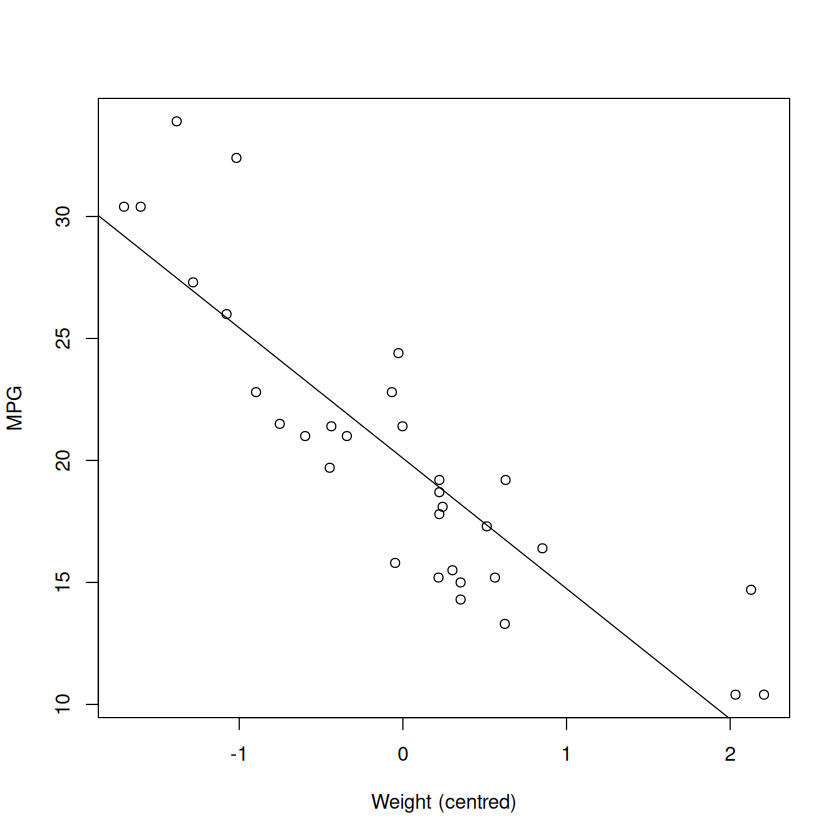

In [20]:
plot(x=wt.cent, y=mtcars$mpg, xlab="Weight (centred)", ylab="MPG")
abline(reg=reg.cent)

We could also centre the MPG variable. This would render the average value of MPG for an average value of Weight 0. This means we can drop the intercept and return to regression through the origin. This is because the origin now sits in the *middle* of our data, rather than miles away from the data (as was the case before).


Call:
lm(formula = mpg.cent ~ 0 + wt.cent, data = mtcars)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.5432 -2.3647 -0.1252  1.4096  6.8727 

Coefficients:
        Estimate Std. Error t value Pr(>|t|)    
wt.cent   -5.345      0.550  -9.717 6.33e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.996 on 31 degrees of freedom
Multiple R-squared:  0.7528,	Adjusted R-squared:  0.7449 
F-statistic: 94.42 on 1 and 31 DF,  p-value: 6.332e-11


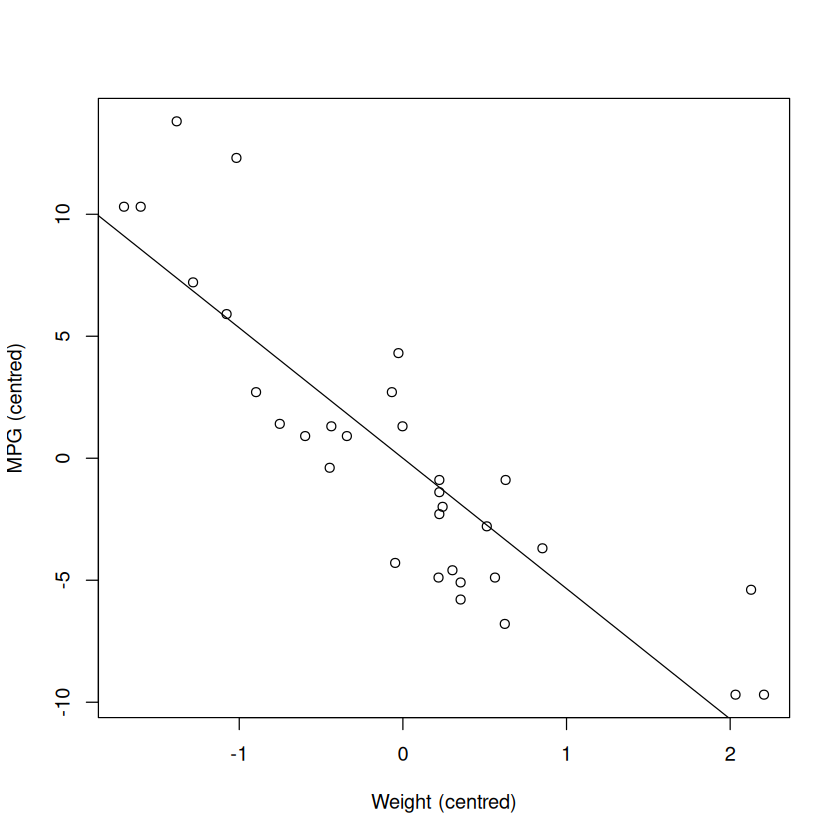

In [21]:
wt.cent    <- mtcars$wt  - mean(mtcars$wt)
mpg.cent   <- mtcars$mpg - mean(mtcars$mpg)
reg.cent.2 <- lm(mpg.cent ~ 0 + wt.cent, data=mtcars) # or mpg.cent ~ wt.cent - 1
summary(reg.cent.2)

plot(x=wt.cent, y=mpg.cent, xlab="Weight (centred)", ylab="MPG (centred)")
abline(reg=reg.cent.2)

Notice that the fit is exactly the same, we have just removed the need for an intercept. In practice, there is often little call for doing this, especially as it then causes some interpretational issues given the mean-centered scale. This can be overcome by adding the means back in when visualising the model fit, but this usually just amounts to unnecessary fiddling for limited gain. *However*, this can be instructive in terms of understanding how regression models work and why the intercept is there in the first place.

## Visualising Regression 
As a final topic in this workshop, we will discuss more about visualising regression models. Although the base `R` graphics are perfectly serviceable, in terms of publication it is likely you will want to use a decided plotting library, such as `ggplot2`. In the sections below, we will provide examples of plotting simple regression and multiple regression in `ggplot2`. We will then provide a final example in base `R` of plotting the 3-dimensional regression plane, for situations where you may find this useful.

### Simple Regession and `ggplot2`
The code below provides a basic example of plotting simple regression using the `ggplot2` framework. This is clearly more verbose and more effort than base `R`, but for the purpose of creating high-quality visualisations, there are few more powerful alternatives. Of note is that, for the purpose of something like a data analysis report, it is rarely worth your time making a pretty plot. This effort should only really be spent when you are publishing work or including results in a presentation or poster. Make sure you do not get side-tracked playing with `ggplot2` in a context where it is not necessary. All this demonstrates is an ability to focus on the most important elements of the data analysis.

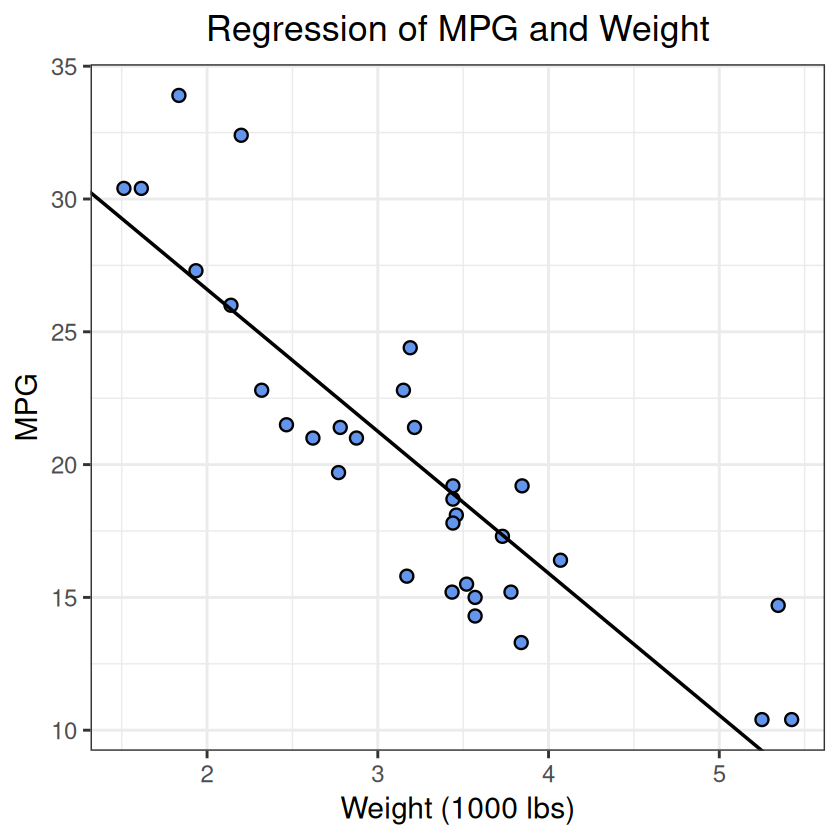

In [22]:
library(ggplot2)

mod  <- lm(mpg ~ wt, data=mtcars)
beta <- coef(mod)

ggplot(mtcars, aes(wt, mpg)) + 
    geom_point(size=3, fill="cornflowerblue", colour="black", pch=21, stroke=1) +
    geom_abline(intercept=beta[1], slope=beta[2], linewidth=1) +
    labs(title="Regression of MPG and Weight", x="Weight (1000 lbs)", y="MPG") + 
    theme_bw(base_size=18) + 
    theme(plot.title=element_text(hjust = 0.5))

<div class="alert alert-block alert-info"> 
<b>ACTIVITY</b> Have a play around with all the numeric graphical parameters (e.g. <code>size</code>, <code>pch</code>, <code>stroke</code>, <code>base_size</code> etc.) and the colour parameters (e.g. <code>fill</code> and <code>colour</code>) to change how the plot is displayed. This should give you a good sense of the flexibility of the visualisation. You could try changing <code>theme_bw</code> to something else as well (you can search online for <code>ggplot2 themes</code>).
</div>

### Multiple Regression and `ggplot2`
In the case of multiple regression, things are a little more complex because we need to use `ggplot2` to create *added variable* plots. This means we need to *residualise* each variable in terms of all other variables in the model before plotting.

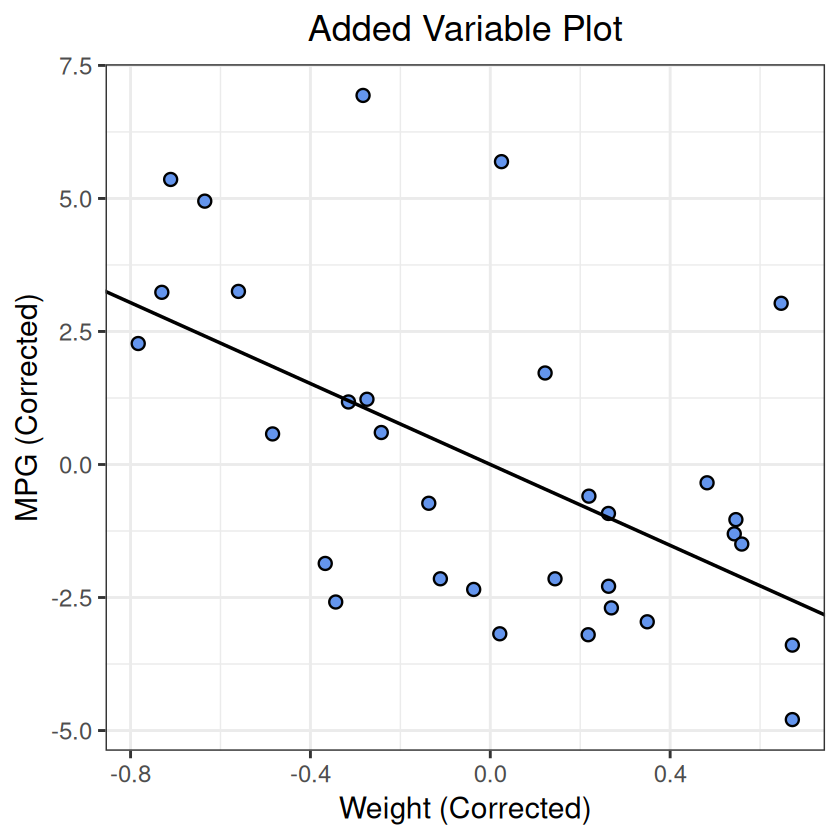

In [23]:
# Full model
multi.reg <- lm(mpg ~ wt + hp + disp, data=mtcars)

#======================================================================================#
# Plot Weight
#======================================================================================#

# Residualise the variables
mpg.resid   <- resid(lm(mpg ~ hp + disp, data=mtcars))
wt.resid    <- resid(lm( wt ~ hp + disp, data=mtcars))
add.var.mod <- lm(mpg.resid ~ wt.resid - 1)

# Data for plotting
plot.data <- data.frame("mpg"=mpg.resid, "wt"=wt.resid)
beta      <- coef(add.var.mod)

# Create plot
ggplot(plot.data, aes(wt, mpg)) + 
    geom_point(size=3, fill="cornflowerblue", colour="black", pch=21, stroke=1) +
    geom_abline(intercept=0, slope=beta[1], linewidth=1) +
    labs(title="Added Variable Plot", x="Weight (Corrected)", y="MPG (Corrected)") + 
    theme_bw(base_size=18) + 
    theme(plot.title=element_text(hjust = 0.5))

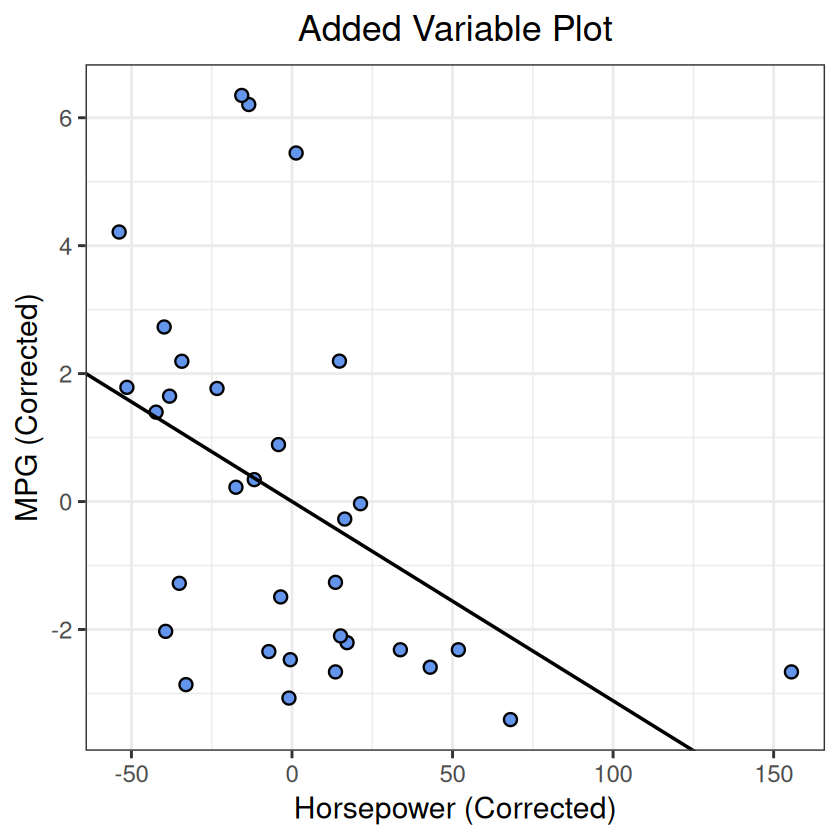

In [24]:
#======================================================================================#
# Plot Horsepower
#======================================================================================#

# Residualise the variables
mpg.resid   <- resid(lm(mpg ~ wt + disp, data=mtcars))
hp.resid    <- resid(lm( hp ~ wt + disp, data=mtcars))
add.var.mod <- lm(mpg.resid ~ hp.resid - 1)

# Data for plotting
plot.data <- data.frame("mpg"=mpg.resid, "hp"=hp.resid)
beta      <- coef(add.var.mod)

# Create plot
ggplot(plot.data, aes(hp, mpg)) + 
    geom_point(size=3, fill="cornflowerblue", colour="black", pch=21, stroke=1) +
    geom_abline(intercept=0, slope=beta[1], linewidth=1) +
    labs(title="Added Variable Plot", x="Horsepower (Corrected)", y="MPG (Corrected)") + 
    theme_bw(base_size=18) + 
    theme(plot.title=element_text(hjust = 0.5))

<div class="alert alert-block alert-info"> 
<b>ACTIVITY</b> Can you use the pattern here to create the added variable plot for <code>disp</code>? 
</div>

### Visualising the Regression Plane
As a final topic, you may want to visualise the regression plane when you have a multiple regression with 2 predictor variables. Although advanced 3D rendering packages such as `rgl` exist, the most simple non-interactive 3D scatter plot with the regression plane can be created in base `R` using the code below. You do not need to understand all of this, but could easily adapt it for any of your own 2-variable regression models.

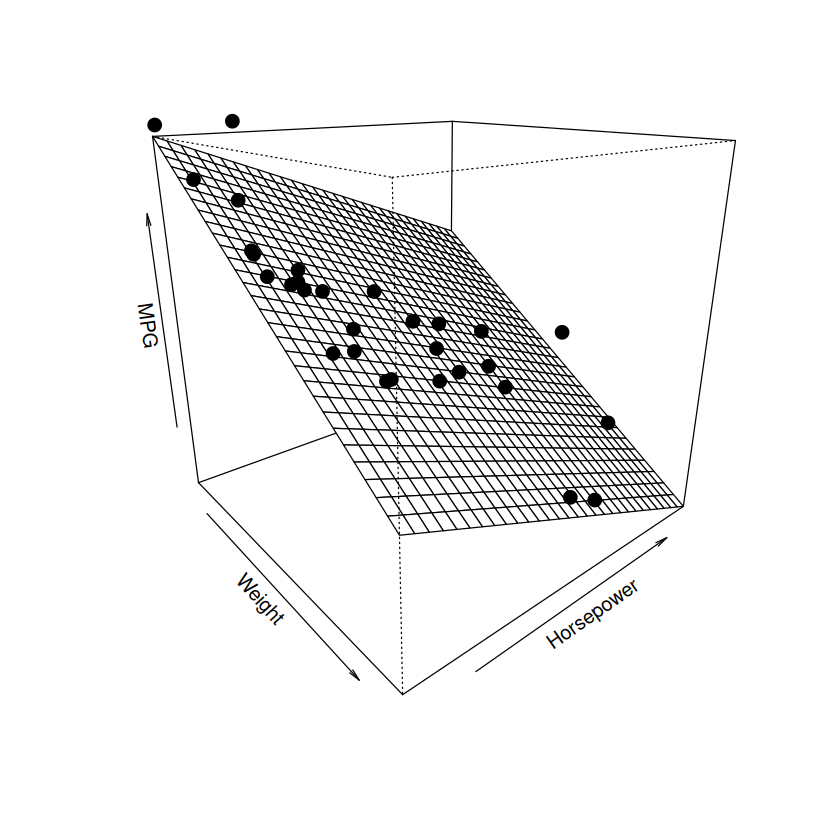

In [25]:
# data (just change this in future)
y       <- mtcars$mpg
x1      <- mtcars$wt
x2      <- mtcars$hp
x.label <- "Weight"
y.label <- "Horsepower"
z.label <- "MPG"

# model
plot.mod <- lm(y ~ x1 + x2)

# regression plane as a grid
x.axis  <- seq(min(x1), max(x1), length.out=30)   # x-axis
y.axis  <- seq(min(x2), max(x2), length.out=30)   # z-axis
grid    <- expand.grid(x1=x.axis, x2=y.axis)
fit     <- matrix(predict(plot.mod, newdata=grid), nrow=length(x.axis), ncol=length(y.axis))

# draw regression plane
pr <- persp(x.axis, y.axis, fit, xlab=x.label, ylab=y.label, zlab=z.label, 
            theta=50, phi=20)

# Add data points
points(trans3d(x1, x2, y, pr), pch=19, cex=1.5, col="black")

<div class="alert alert-block alert-info"> 
<b>ACTIVITY</b> Try changing the values of <code>theta</code> and <code>phi</code> to change the perspective of the visualisation. You can also change the value of <code>pch</code> to change the symbol used for the data points (refer to a website such as <a href="https://www.r-bloggers.com/2021/06/r-plot-pch-symbols-different-point-shapes-in-r/">this</a> to see all the symbols available), change the value of <code>cex</code> to adjust the symbol size and change the colour of the points to whatever you like. You could also try replacing the variables and labels with other options from <code>mtcars</code>, to see how this visualisation can be easily adpated.
</div>

## Summary
In this workshop, we have covered ...